In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [23]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [24]:
# Load data
results_files = [
    "20211007-135249.csv",
#     "20211007-084741.csv", # benchsym switch backend
#     "20211006-143434.csv", # more problem swtich backend
#     "20210915-111700.csv",
#     "results-compilespace.csv",
]

df_raw = pd.concat(map(lambda f: pd.read_csv(f"results/{f}"), results_files), ignore_index=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Benchmark                         100 non-null    object 
 1   Mode                              100 non-null    object 
 2   Threads                           100 non-null    int64  
 3   Samples                           100 non-null    int64  
 4   Score                             100 non-null    float64
 5   Score Error (99.9%)               100 non-null    float64
 6   Unit                              100 non-null    object 
 7   Param: metaborgVersion            100 non-null    object 
 8   Param: optimisationLevel          100 non-null    int64  
 9   Param: problemSize                100 non-null    int64  
 10  Param: sharedConstructors         100 non-null    object 
 11  Param: switchImplementation       100 non-null    object 
 12  Param: sw

In [25]:
for col in ["Score", "Score Error (99.9%)"]:
    if col in df_raw and df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

In [26]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [27]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Param: sharedConstructors,Param: switchImplementation,Param: switchImplementationOrder
0,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,4.442057,1.080371,s/op,2.6.0-SNAPSHOT,4,10,on,elseif,NaN
1,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,1.265929,0.232455,s/op,2.6.0-SNAPSHOT,4,10,on,switch,arity-name
2,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,8.076902,3.395257,s/op,2.6.0-SNAPSHOT,4,11,on,elseif,NaN
3,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,1.834433,0.107102,s/op,2.6.0-SNAPSHOT,4,11,on,switch,arity-name
4,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,15.851476,4.376207,s/op,2.6.0-SNAPSHOT,4,12,on,elseif,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,benchmark.stratego2.execution.Quicksort.run,ss,1,5,195.190887,24.134691,s/op,2.6.0-SNAPSHOT,4,20,on,switch,arity-name
96,benchmark.stratego2.execution.Sieve.run,ss,1,5,0.633835,0.021574,s/op,2.6.0-SNAPSHOT,4,20,on,elseif,NaN
97,benchmark.stratego2.execution.Sieve.run,ss,1,5,0.560029,0.067739,s/op,2.6.0-SNAPSHOT,4,20,on,switch,arity-name
98,benchmark.stratego2.execution.Sieve.run,ss,1,5,8.869950,1.808449,s/op,2.6.0-SNAPSHOT,4,100,on,elseif,NaN


In [28]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Param: sharedConstructors,Param: switchImplementation,Param: switchImplementationOrder,Stage,Problem
0,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,4.442057,1.080371,s/op,2.6.0-SNAPSHOT,4,10,on,elseif,NaN,run,Benchexpr
1,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,1.265929,0.232455,s/op,2.6.0-SNAPSHOT,4,10,on,switch,arity-name,run,Benchexpr
2,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,8.076902,3.395257,s/op,2.6.0-SNAPSHOT,4,11,on,elseif,NaN,run,Benchexpr
3,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,1.834433,0.107102,s/op,2.6.0-SNAPSHOT,4,11,on,switch,arity-name,run,Benchexpr
4,benchmark.stratego2.execution.Benchexpr.run,ss,1,5,15.851476,4.376207,s/op,2.6.0-SNAPSHOT,4,12,on,elseif,NaN,run,Benchexpr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,benchmark.stratego2.execution.Quicksort.run,ss,1,5,195.190887,24.134691,s/op,2.6.0-SNAPSHOT,4,20,on,switch,arity-name,run,Quicksort
96,benchmark.stratego2.execution.Sieve.run,ss,1,5,0.633835,0.021574,s/op,2.6.0-SNAPSHOT,4,20,on,elseif,NaN,run,Sieve
97,benchmark.stratego2.execution.Sieve.run,ss,1,5,0.560029,0.067739,s/op,2.6.0-SNAPSHOT,4,20,on,switch,arity-name,run,Sieve
98,benchmark.stratego2.execution.Sieve.run,ss,1,5,8.869950,1.808449,s/op,2.6.0-SNAPSHOT,4,100,on,elseif,NaN,run,Sieve


In [29]:
program_text = """
module calls

imports libstrategolib

signature

sorts
   S

constructors
   nullary_constructor : S 
   unary_constructor : S -> S 
   nary_constructor : S * S * S -> S 
   nullary_function : S 
   unary_function : S -> S 
   nary_function : S * S * S -> S 
   a : S 
   b : S 
   c : S 
   d : S 
   e : S 
   f : S 

rules
   REC_E: nullary_function() -> nullary_constructor()
   REC_E: unary_function (x) -> unary_constructor (x)
   REC_E: nary_function (x, y, z) -> nary_constructor (x, y, z)
   REC_E: a() -> nullary_constructor()
   REC_E: b() -> unary_constructor (nullary_constructor())
   REC_E: c() -> nary_constructor (nullary_constructor(), nullary_constructor(), nullary_constructor())
   REC_E: d() -> nullary_function()
   REC_E: e() -> unary_function (nullary_function())
   REC_E: f() -> nary_function (nullary_function(), nullary_function(), nullary_function())

strategies
   eval = memo (innermost (REC_E))
   eval-and-print = eval ; debug (!"result = ")
   main = 
      (<eval-and-print> nullary_constructor()) ;
      (<eval-and-print> unary_constructor (nullary_constructor())) ;
      (<eval-and-print> nary_constructor (nullary_constructor(), nullary_constructor(), nullary_constructor())) ;
      (<eval-and-print> nullary_function()) ;
      (<eval-and-print> unary_function (nullary_function())) ;
      (<eval-and-print> nary_function (nullary_function(), nullary_function(), nullary_function())) ;
      <exit> 0

"""

In [36]:
df["Param: problemSize"].astype("str").mask(df["Param: problemSize"]==-1, "")

0      10
1      10
2      11
3      11
4      12
     ... 
95     20
96     20
97     20
98    100
99    100
Name: Param: problemSize, Length: 100, dtype: object

In [37]:
import re
import os

# Add number of unique constructors to problems
# cons_regex_pat = r"\bconstructors\b\W*(?:\s*(\w*)\s*:.*\s*)*\W*\brules\b"

cons_area_regex = r"^\s*constructors\s*$((?:.*\n)*)^\s*rules\s*$"
cons_area_pat = re.compile(cons_area_regex, re.MULTILINE)

cons_regex = r"\w+\s*:.*\S"
cons_pat = re.compile(cons_regex)

def find_constructors(p):
    cons_areas = cons_area_pat.findall(p)
    cons_groups = list(map(cons_pat.findall, cons_areas))
    conses = set().union(*cons_groups)
    return conses

def count_constructors_in_file(program_name):
    p_program = os.path.join("..", "src", "main", "resources", program_name + ".str2")
    with open(p_program, 'r') as f_program:
        contents = f_program.read()
        conses = find_constructors(contents)
        return len(conses)

df["Number of constructors"] = (df["Problem"].str.lower() + df["Param: problemSize"].astype("str").mask(df["Param: problemSize"]==-1, "")).map(count_constructors_in_file)

In [38]:
## Plot-specific settings
configs = [
    {
        "problems": {"Benchexpr", "Benchsym", "Benchtree", "Bubblesort", "Factorial", "Fibonacci", "Hanoi", "Mergesort", "Quicksort", "Sieve"},
        "stages": {"run"},
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": {"compileStratego", "compileJava", "Java space", "Class space"},
        "settings": {"ylim": (0, None)}
    },
    {
        "stages": {"Java space", "Class space"},
        "settings": {"ylabel": "Size (bytes)"}
    }
]

In [39]:
from pandas.core.common import flatten

def configure_grid(g: sns.FacetGrid, problem=None):
    ## Global settings
    g.set_ylabels("Time (s)")
    g.set_xlabels("Input size")

    for ax in flatten(g.axes):
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    # Specific settings
    try:
        for (row_val, col_val), ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or row_val in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    except (ValueError):
        for col_val, ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or problem in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    finally:
        return g

In [40]:
df_scaledproblem = df[df["Param: problemSize"] != -1]

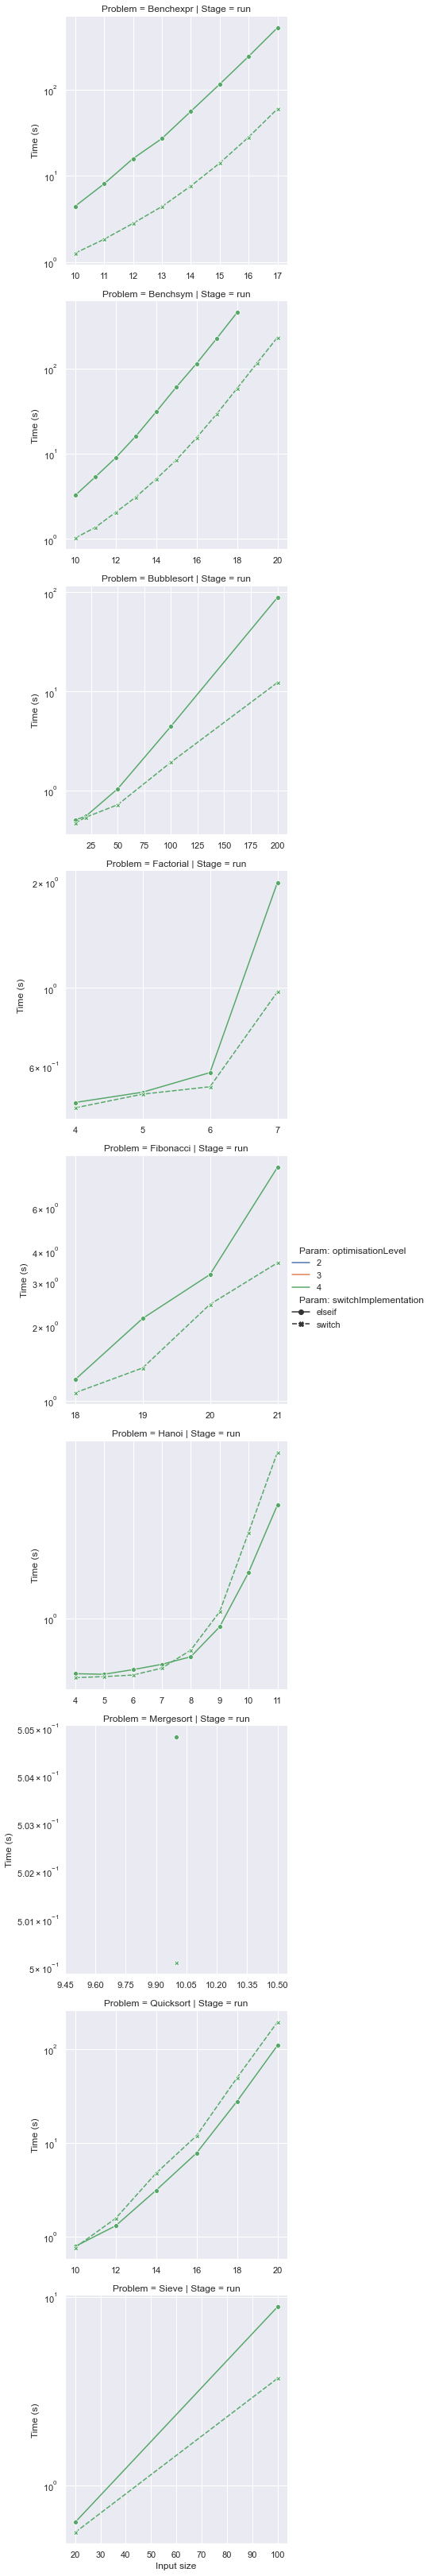

In [41]:
g = configure_grid(sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col="Stage",
    col_order=[s for s in ["compileStratego", "Java space", "compileJava", "Class space", "run"] if s in df_scaledproblem["Stage"].values],
    style="Param: switchImplementation",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-allstages.png")

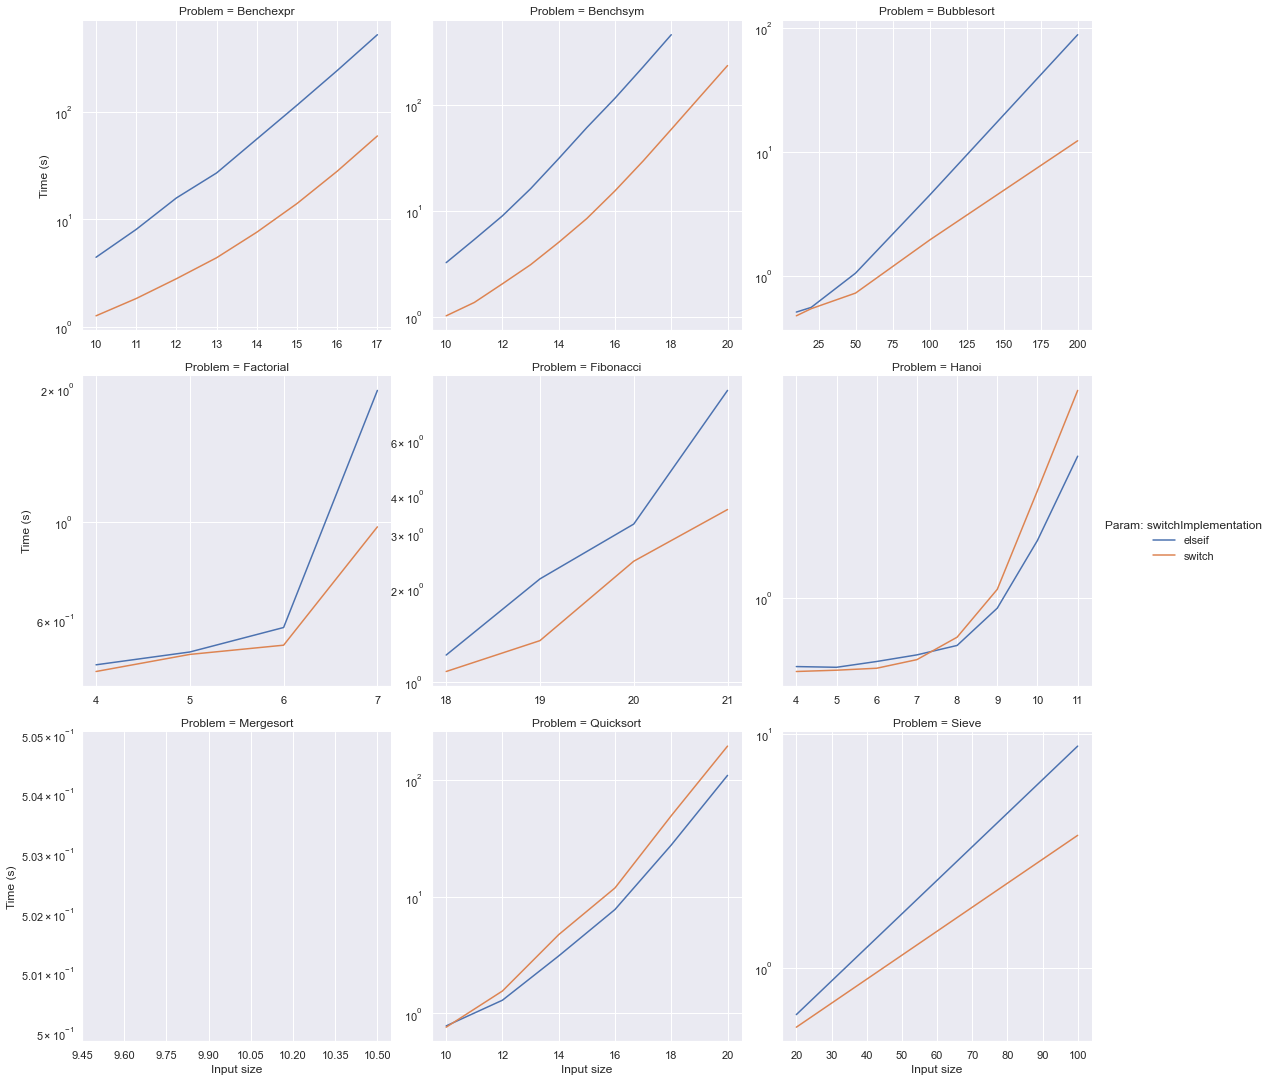

In [44]:
# Runtimes for DFA switch backends (per problem)

g = configure_grid(sns.relplot(
    data=df_scaledproblem[df_scaledproblem["Stage"] == "run"],
    x="Param: problemSize",
    y="Score",
    col="Problem",
    col_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col_wrap=3,
#     style="Param: switchImplementation",
    hue="Param: switchImplementation",
#     hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

g.set(yscale="log")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-runtime.png")

In [144]:
df_ratios = df[df["Stage"] == "run"].pivot(index=["Param: switchImplementation"], columns=["Benchmark", "Param: problemSize", "Number of constructors", "Problem"], values="Score").T

# df_ratios["Ratio"] = df_ratios["elseif"] / df_ratios["switch"]
df_ratios["Ratio"] = df_ratios["switch"] / df_ratios["elseif"]

df_ratios.sort_values("Ratio")

# df_ratios.columns.to_series().apply(''.join)

# df[df[""]]

Param: switchImplementation                                                                                         elseif  \
Benchmark                                          Param: problemSize Number of constructors Problem                         
benchmark.stratego2.execution.Benchexpr.run         17                92                     Benchexpr          524.748870   
                                                    16                92                     Benchexpr          243.438724   
                                                    15                92                     Benchexpr          115.792684   
benchmark.stratego2.execution.Benchsym.run          18                92                     Benchsym           454.717882   
                                                    17                92                     Benchsym           226.435517   
                                                    16                92                     Benchsym           114.782027   
benchmark.stratego2.execution.Benchexpr.run         14                92                     Benchexpr           56.022835   
benchmark.stratego2.execution.Bubblesort.run        200               13                     Bubblesort          88.467470   
benchmark.stratego2.execution.Benchsym.run          15                92                     Benchsym            60.776917   
benchmark.stratego2.execution.Benchexpr.run         13                92                     Benchexpr           27.092641   
benchmark.stratego2.execution.Benchsym.run          14                92                     Benchsym            31.033343   
benchmark.stratego2.execution.Benchexpr.run         12                92                     Benchexpr           15.851476   
benchmark.stratego2.execution.Benchsym.run          13                92                     Benchsym            16.137150   
benchmark.stratego2.execution.Benchexpr.run         11                92                     Benchexpr            8.076902   
benchmark.stratego2.execution.Benchsym.run          12                92                     Benchsym             8.970249   
                                                    11                92                     Benchsym             5.366792   
benchmark.stratego2.execution.Benchexpr.run         10                92                     Benchexpr            4.442057   
benchmark.stratego2.execution.Benchsym.run          10                92                     Benchsym             3.249572   
benchmark.stratego2.execution.Fibonacci.run         21                4                      Fibonacci            8.724303   
benchmark.stratego2.execution.Sieve.run             100               40                     Sieve                8.869950   
benchmark.stratego2.execution.Bubblesort.run        100               13                     Bubblesort           4.475117   
benchmark.stratego2.execution.Factorial.run         7                 5                      Factorial            1.987596   
benchmark.stratego2.execution.Fibonacci.run         19                4                      Fibonacci            2.150377   
benchmark.stratego2.execution.Bubblesort.run        50                13                     Bubblesort           1.050842   
benchmark.stratego2.execution.Fibonacci.run         20                4                      Fibonacci            3.231771   
benchmark.stratego2.execution.Sieve.run             20                40                     Sieve                0.633835   
benchmark.stratego2.execution.Fibonacci.run         18                4                      Fibonacci            1.220930   
benchmark.stratego2.execution.Factorial.run         6                 5                      Factorial            0.576536   
benchmark.stratego2.execution.Bubblesort.run        10                13                     Bubblesort           0.509362   
benchmark.stratego2.execution.Hanoi.run             6                 31                     H

In [141]:
df_ratios_flat = df_ratios.melt(value_vars=["Ratio"], value_name="Ratio", ignore_index=False)
# df_ratios_flat.index = df_ratios_flat.index.to_flat_index()
# df_ratios_flat.reset_index()
df_ratios_flat.index

<ipython-input-141-7e40de4d4adf>:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_ratios_flat = df_ratios.melt(value_vars=["Ratio"], value_name="Ratio", ignore_index=False)


Index(['Param: switchImplementation', 'Ratio'], dtype='object')

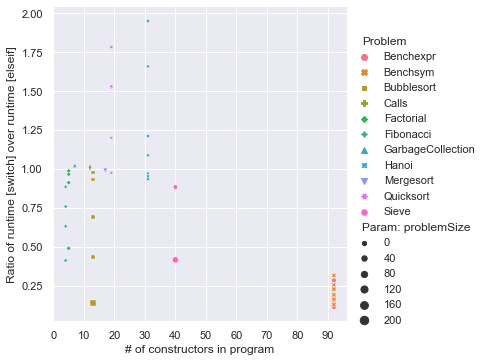

In [102]:
# Runtimes for DFA switch backends (against number of constructors)

g = configure_grid(sns.relplot(
    data=df_ratios,
    x="Number of constructors",
    y="Ratio",
    style="Problem",
    hue="Problem",
    size="Param: problemSize",
    kind="scatter",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# g.set(yscale="log")
g.set_ylabels("Ratio of runtime [switch] over runtime [elseif]")
g.set_xlabels("# of constructors in program")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-backend-constructors.png")

In [116]:
# g = sns.boxplot(
#     data=df_ratios,
#     x="Number of constructors",
#     y="Ratio",
#     hue="Problem"
# )

df_ratios.columns#.to_flat_index()
# df_ratios.columns.get_level_values(0) + '_' +  df_ratios.columns.get_level_values(1)

IndexError: Too many levels: Index has only 1 level, not 2

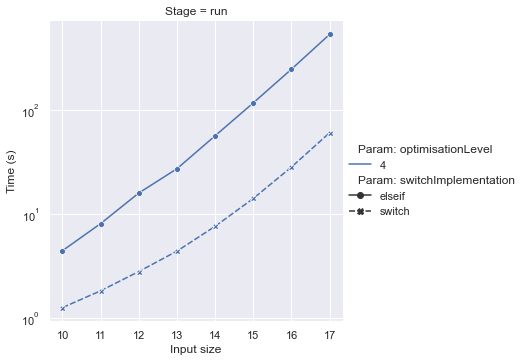

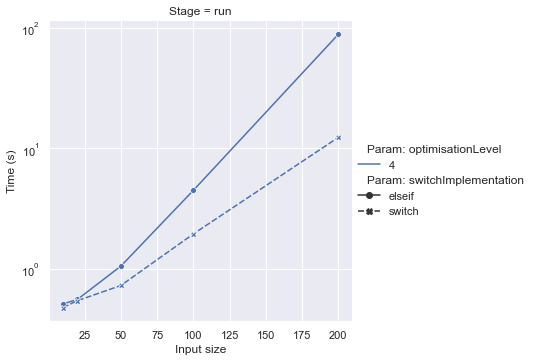

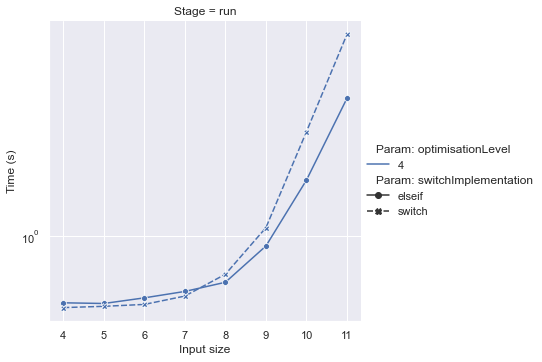

In [94]:
for problem in ["Benchexpr", "Bubblesort", "Hanoi"]:
    df_problem = df_scaledproblem[df_scaledproblem["Problem"] == problem]
    
    cols = [s for s in ["compileStratego", "compileJava", "run", "Java space", "Class space"] if s in df_problem["Stage"].values]

    g = configure_grid(sns.relplot(
        data=df_problem,
        x="Param: problemSize",
        y="Score",
#         row="Problem",
#         row_order=np.sort(np.unique(df_problem["Problem"].values)),
        col_wrap=min(3, len(cols)),
        col="Stage",
        col_order=cols,
        style="Param: switchImplementation",
        hue="Param: optimisationLevel",
        hue_order=[l for l in ["2", "3", "4"] if l in df_problem["Param: optimisationLevel"].values],
        kind="line",
    #     err_style="band",
        markers=True,
        facet_kws=dict(
            sharex=False, 
            sharey=False,
        ),
    ), problem)

    # Save figure to file
    plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-{problem}.png")

In [96]:
df_unscaledproblem = df[df["Param: problemSize"] == -1]

print(df_unscaledproblem.to_latex(
    columns=["Problem", "Stage", "Samples", "Score", "Score Error (99.9%)", "Param: optimisationLevel", "Param: switchImplementation"]
))

df_unscaledproblem

\begin{tabular}{lllrrrll}
\toprule
{} &            Problem & Stage &  Samples &     Score &  Score Error (99.9\%) & Param: optimisationLevel & Param: switchImplementation \\
\midrule
46 &              Calls &   run &        5 &  0.464543 &             0.050381 &                        4 &                      elseif \\
47 &              Calls &   run &        5 &  0.468903 &             0.047839 &                        4 &                      switch \\
64 &  GarbageCollection &   run &        5 &  0.475807 &             0.072651 &                        4 &                      elseif \\
65 &  GarbageCollection &   run &        5 &  0.486342 &             0.079655 &                        4 &                      switch \\
\bottomrule
\end{tabular}



,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Param: sharedConstructors,Param: switchImplementation,Param: switchImplementationOrder,Stage,Problem,Number of constructors
46,benchmark.stratego2.execution.Calls.run,ss,1,5,0.464543,0.050381,s/op,2.6.0-SNAPSHOT,4,-1,on,elseif,NaN,run,Calls,12
47,benchmark.stratego2.execution.Calls.run,ss,1,5,0.468903,0.047839,s/op,2.6.0-SNAPSHOT,4,-1,on,switch,arity-name,run,Calls,12
64,benchmark.stratego2.execution.GarbageCollectio...,ss,1,5,0.475807,0.072651,s/op,2.6.0-SNAPSHOT,4,-1,on,elseif,NaN,run,GarbageCollection,7
65,benchmark.stratego2.execution.GarbageCollectio...,ss,1,5,0.486342,0.079655,s/op,2.6.0-SNAPSHOT,4,-1,on,switch,arity-name,run,GarbageCollection,7
